In [1]:
"""
Created on Wed Jun 19 17:45:50 2019

@author: ggusmao3
"""

'\nCreated on Wed Jun 19 17:45:50 2019\n\n@author: ggusmao3\n'

## Forward ANN ODE

Using JAX to reproduce results from:

[**Solving coupled ODEs with a neural network and autograd**](http://kitchingroup.cheme.cmu.edu/blog/category/ode/ ) (Kitchin's Group)

   - Solves the forward ODE for kinetic systems using ANN.
   - Show example of automatic differentiation with *autograd*.
   - Kitchin's work on the forward problem will be used as starting point for the inverse problem.

-*- coding: utf-8 -*-

### Necessary Libraries

In [2]:
from __future__ import print_function, division, absolute_import
import jax.numpy as np
from numpy.random import choice
from jax import grad, jit, vmap, jacobian, jacfwd, jacrev
from jax import random
from jax.scipy.special import logsumexp
from jax.experimental import optimizers
from jax.config import config
from jax.tree_util import tree_map
config.update("jax_debug_nans", True)
config.update('jax_enable_x64', True)
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
import itertools

### Set of helper functions based on [JAX tutorials](https://colab.research.google.com/github/google/jax/blob/master/notebooks/neural_network_with_tfds_data.ipynb) ***(Google Colabs)***

*Dense Neural Network: random initialization of layers weights and biases.*

In [3]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

*Own modification of random_layer_params to generate model parameters.*

In [4]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_model_params(m, key, scale=1e-2):
    #w_key, b_key = random.split(key)
    #print(tuple(scale * random.normal(key, (m, 1))))
    return (scale * random.normal(key, (m,)))#, scale * random.normal(b_key, (n,))

Network and model initialization functions

In [5]:
# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key, scale):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [6]:
def init_model_params(size, key, scale):
 key = random.split(key,2)[-1] 
 return [random_model_params(s, key, scale) for s in size]

Universal activation function to be used. (JIT precompiled)

In [7]:
@jit
def act_fun(x):
    #return np.maximum(0, x)
    #return np.nan_to_num(x / (1.0 + np.exp(-x)))
    #return x / (1.0 + np.exp(-x))
    return 2./(1.+np.exp(-2.*x))-1.
    #return 0.5*np.tanh(x) + 0.5*x / (1.0 + np.exp(-x))
    #return(x)

ANN evaluator for *state* variables. (JIT precompiled)

In [8]:
@jit
def state(params, t):
    # per-example stateions
    activations = t
    for w, b in params[:-1]:
        outputs = np.dot(w, activations) + b
        activations = act_fun(outputs)
    
    final_w, final_b = params[-1]
    y = (np.dot(final_w, activations) + final_b)
    #y = y / y.sum()
    return y

# Make a batched version of the `state` function
batched_state = vmap(state, in_axes=(None,0))#, in_axes=(None, 0))

Derivatives of state variables with respect to inputs using autograd `jacfwd` for tall Jacobians. (JIT precompiled)

In [9]:
@jit
def diff_state(params,t):
        i = np.arange(len(t))
        #return (jacobian(batched_state,argnums=1)(params,t)[i,:,i,0])
        return np.nan_to_num(jacfwd(lambda t : batched_state(params,t))(t)[i,:,i,0])

### Kinetic Model Definitions

Model parameters (rate constants): `model_params0`  
Boundary conditions (concentrations at $t=0$): `bc0`

In [10]:
model_params0 = np.array([1.,1.])
bc0=np.array([1.0,0.0,0.0])

/home/ggusmao3/.pyenv/versions/ML/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Model function, `x` are state variables, `t` the independet variable (e.g. time) and `model_params` packs all potential model parameters to be parsed to the function. The latter is important if they are actually changed in a different setup, e.g. solving the inverse problem, which will be shown in the next tutorial.

In [11]:
@jit
def model(batch, model_params):
    #print('model x: {}'.format(x))
    #print('model params: {}'.format(model_params))
    x, t = batch
    k  = model_params
    return np.array([[-k[0]*x[0]],
                    [k[0]*x[0]-k[1]*x[1]],
                    [k[1]*x[1]]])

batched_model = lambda batch, model_params : vmap(model,in_axes=(0,None))(batch,model_params)[:,:,0]#, in_axes=(None, 0)

### Numerical solution

The following numerical solution using `scipy.integrate`'s `solve_ivp` initial-value-problem solver will be used as benchmark for the NN-based equivalent solution.

In [12]:
%%time

from scipy.integrate import solve_ivp

def ode(t,C):
    return model([C,t], model_params0).flatten()

tmax = 10. # max time to evaluate
n_points = int(20*tmax) # number of points

#t_eval = np.logspace(0,np.log10(tmax),n_points)-1.
t_eval = np.linspace(0,tmax,n_points)
sol = solve_ivp(ode, (0, tmax), bc0, t_eval = t_eval)

CPU times: user 58 ms, sys: 731 µs, total: 58.8 ms
Wall time: 62 ms


#### Results

Text(0.5, 1.0, 'ODE Numerical Solution')

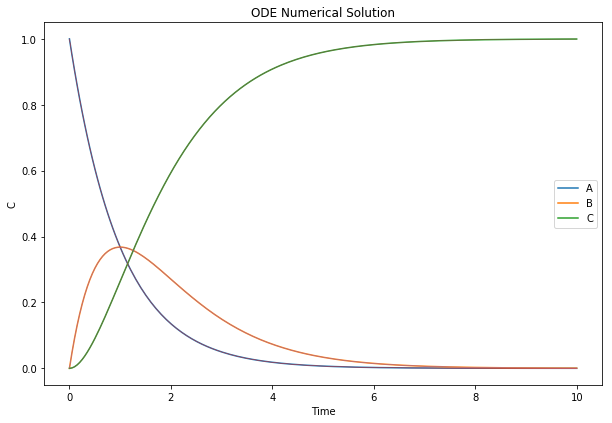

In [13]:
plt.figure(figsize=[10,10*2./3])
t = sol.t
x0 = sol.y.T
x = x0
lines = plt.plot(sol.t, x0)
plt.plot(sol.t, x,'-',ms=5,lw=0.5)
plt.xlabel('Time')
plt.ylabel('C');
plt.legend(iter(lines), ['A', 'B', 'C'])
plt.title('ODE Numerical Solution')

### NN ODE forward solution

Pack `t` as the generic `data` holder for the NN training.

In [14]:
t = t.reshape(-1,1)
data = t

#### Error function

Returns:

   `err_model`: sum of square-errors between NN derivatives with respect to inputs and those coming from the source model.   
   `err_bc`: boundary conditions.

In [15]:
@jit
def get_errors(nn_params,batch):
    t = batch
    pred_x = batched_state(nn_params,t)
    err_model = (diff_state(nn_params,t)-batched_model([pred_x,t.reshape(-1,1)],model_params0))**2 
    err_bc = 100*(batched_state(nn_params,np.array(0).reshape(-1,1))-bc0)**2
    return [err_model, err_bc]

#### Loss function

Returns the sum of individual errors from `get_errors`.

In [16]:
@jit
def loss(nn_params, batch):
    return np.array([_.sum() for _ in get_errors(nn_params,batch)]).sum()

#### NN intialization parameters

In [17]:
layer_sizes = [1, 20, 3]
nn_scale = 0.01

key = random.PRNGKey(0)

nn_params = init_network_params(layer_sizes, key, nn_scale)

#### Training settings

In [18]:
num_epochs = 100
num_eras = int(5e1)
batch_size = n_points
model_params = model_params0

#### Training Loop

In [19]:
opt_init_nn, opt_update_nn, get_params_nn = optimizers.adam(1e-3, b1=0.9, b2=0.9999, eps=1e-100)
    
@jit
def step(i, opt_state_nn, batch):
    nn_params = get_params_nn(opt_state_nn)
    grads_nn = grad(loss,argnums=0)(nn_params, batch)  
    return opt_update_nn(i, grads_nn, opt_state_nn)
 
itercount = itertools.count()        

opt_state_nn = opt_init_nn(nn_params)

for j in range(num_eras):
    sel = random.shuffle(random.PRNGKey(j),np.arange(n_points))    
    batch = data[:batch_size]
    for i in range(int(num_epochs)):
        nn_params = get_params_nn(opt_state_nn)
        opt_state_nn = step(next(itercount), opt_state_nn, batch) 
    nn_params = get_params_nn(opt_state_nn) 
    loss_it_sample = loss(nn_params, batch)    
    loss_it_batch = loss(nn_params, data)
    err_model, err_bc = [_.sum() for _ in get_errors(nn_params,data)]
    print('Iteration: {:4d}, Loss Batch: {:.5e}, Loss Data: {:.5e}, Fit Model: {:.5e}'.format(i,loss_it_sample,loss_it_batch,err_model))
    clear_output(wait=True)    

Iteration:   99, Loss Batch: 1.09170e-02, Loss Data: 1.09170e-02, Fit Model: 1.09074e-02


### Forward ANN ODE results

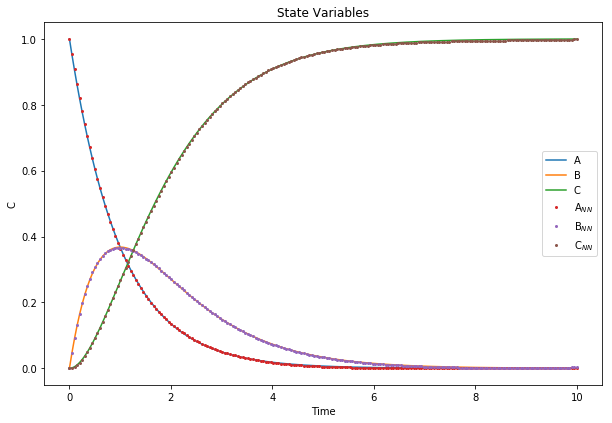

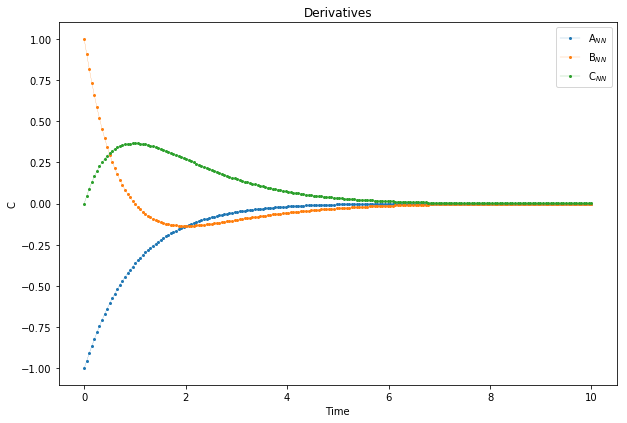

In [20]:
plt.figure(figsize=[10,10*2./3])
nn_params = get_params_nn(opt_state_nn)
lines = plt.plot(sol.t, x0)
lines += plt.plot(t,batched_state(nn_params, t),'o',lw=0.2,ms=2)
plt.legend(iter(lines), ['A', 'B', 'C','A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('State Variables')
plt.xlabel('Time')
plt.ylabel('C');
plt.figure(figsize=[10,10*2./3])
plt.plot(t,batched_model([batched_state(nn_params,t),t],model_params0),'-o',lw=0.2,ms=2)
plt.legend(['A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('Derivatives')
plt.xlabel('Time')
plt.ylabel('C');